In [37]:
import pandas as pd

In [38]:
conv_posters=pd.read_csv("cd_conventional_posters_subs.csv")
conv_commenters=pd.read_csv("cb_conventional_commenters_subs.csv")

alt_posters=pd.read_csv("posters_subreddit_final.csv")
alt_commenters=pd.read_csv("commenters_subreddit_final.csv")

pol_subs=pd.read_csv("political_subreddits_scores.csv")



In [39]:
len(pol_subs)

685

In [40]:
# tansform pol_subs to a dict with subreddit as key and ca_score as value
pol_subs_dict = {}
for index, row in pol_subs.iterrows():
    pol_subs_dict[row['subreddit']] = row['ca_score']

## Posters

In [41]:
# For conventional posters change data form to long
conv_posters_long = pd.melt(conv_posters, id_vars=["Username"], var_name="Number", value_name="Subreddit")
conv_posters_long["Number"] = conv_posters_long["Number"].str.replace("Subreddit_", "")
conv_posters_long=conv_posters_long[conv_posters_long["Number"]!="original_subreddits"]

conv_posters_long["pol_score"]=conv_posters_long["Subreddit"].map(pol_subs_dict)

# I want to see the political subreddits of the conventional posters
conv_posters_long=conv_posters_long[["Username","Subreddit","pol_score"]]
conv_posters_long=conv_posters_long.dropna()

conv_posters_pol = conv_posters_long.groupby("Username").agg(
    mean_pol_score=("pol_score", "mean"),
    sum_pol_score=("pol_score", "sum"),
    med_pol_score=("pol_score", "median")
).reset_index()


# Following the same process for alternative posters
alt_posters_long = pd.melt(alt_posters, id_vars=["Username"], var_name="Number", value_name="Subreddit")
alt_posters_long["Number"] = alt_posters_long["Number"].str.replace("Subreddit_", "")
alt_posters_long=alt_posters_long[alt_posters_long["Number"]!="original_subreddits"]
alt_posters_long["pol_score"]=alt_posters_long["Subreddit"].map(pol_subs_dict)
# I want to see the political subreddits of the alternative posters
alt_posters_long=alt_posters_long[["Username","Subreddit","pol_score"]]
alt_posters_long=alt_posters_long.dropna()
alt_posters_pol = alt_posters_long.groupby("Username").agg(
    mean_pol_score=("pol_score", "mean"),
    sum_pol_score=("pol_score", "sum"),
    med_pol_score=("pol_score", "median")
).reset_index()

# I want to combine the conventional and alternative posters but keep data on the origin
conv_posters_pol["Origin"]="Mainstream"
alt_posters_pol["Origin"]="Alternative"
combined_posters_pol=pd.concat([conv_posters_pol,alt_posters_pol],ignore_index=True)

In [42]:
len(alt_posters_pol)/len(alt_posters), len(conv_posters_pol)/len(conv_posters)

(0.14764448761534726, 0.13785224676313784)

/var/folders/g1/m2905s6d6093hshyj_v9xm380000gn/T/ipykernel_11441/4019060006.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=combined_posters_pol, x="Origin", y="mean_pol_score", palette="muted", inner="quartile")


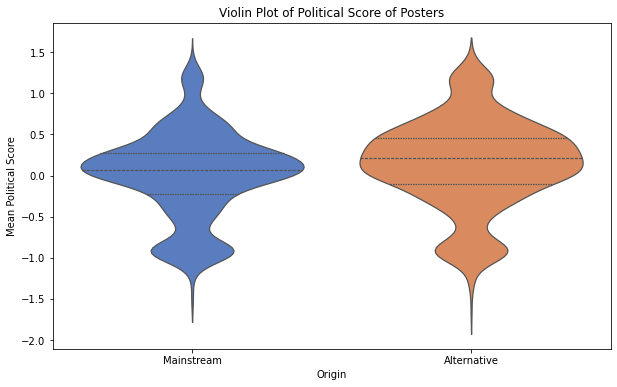

In [43]:
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


# I want to visualize the distribution of combined_posters_pol with a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_posters_pol, x="Origin", y="mean_pol_score", palette="muted", inner="quartile")
plt.title("Violin Plot of Political Score of Posters")
plt.xlabel("Origin")
plt.ylabel("Mean Political Score")
plt.show()


In [44]:
# I want to create a df of the ratio of posters for the two groups who are in each of the 0.5 intervals from -2 to 2
bins = pd.IntervalIndex.from_tuples([(-2, -1.5), (-1.5, -1), (-1, -0.5), (-0.5, 0), (0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2)])
combined_posters_pol["bin"] = pd.cut(combined_posters_pol["mean_pol_score"], bins=bins)
combined_posters_pol["count"] = 1
# I want see the percentage of users in each bin  for each Origin next to each other
combined_posters_pol_ratio = combined_posters_pol.groupby(["Origin", "bin"]).agg(
    count=("count", "sum")
).reset_index()
combined_posters_pol_ratio["total"] = combined_posters_pol_ratio.groupby("Origin")["count"].transform("sum")
combined_posters_pol_ratio["ratio"] = combined_posters_pol_ratio["count"] / combined_posters_pol_ratio["total"]
combined_posters_pol_ratio["bin"] = combined_posters_pol_ratio["bin"].astype(str)
combined_posters_pol_ratio = combined_posters_pol_ratio.pivot(index="bin", columns="Origin", values="ratio").reset_index()

# Sort the bins starting from 2-1.5 and then going down, handling negative numbers correctly
combined_posters_pol_ratio["bin"] = combined_posters_pol_ratio["bin"].str.replace("Interval\\(", "", regex=True).str.replace("\\)", "", regex=True)
combined_posters_pol_ratio["bin"] = combined_posters_pol_ratio["bin"].str.replace(",", "-").str.replace(" ", "")
combined_posters_pol_ratio["bin"] = pd.Categorical(combined_posters_pol_ratio["bin"], 
                                                   categories=["(1.5-2.0]", "(1.0-1.5]", "(0.5-1.0]", "(0.0-0.5]", 
                                                               "(-0.5-0.0]", "(-1.0--0.5]", "(-1.5--1.0]", "(-2.0--1.5]"],
                                                   ordered=True)
combined_posters_pol_ratio = combined_posters_pol_ratio.sort_values("bin", ascending=True)


# Change the Alternative and Mainstream columsn to be percentages
combined_posters_pol_ratio["Alternative"] = combined_posters_pol_ratio["Alternative"] * 100
combined_posters_pol_ratio["Mainstream"] = combined_posters_pol_ratio["Mainstream"] * 100

# Format as percentage
combined_posters_pol_ratio["Alternative"] = combined_posters_pol_ratio["Alternative"].map("{:.2f}%".format)
combined_posters_pol_ratio["Mainstream"] = combined_posters_pol_ratio["Mainstream"].map("{:.2f}%".format)
combined_posters_pol_ratio = combined_posters_pol_ratio.rename(columns={"bin": "Political Score"})

combined_posters_pol_ratio



/var/folders/g1/m2905s6d6093hshyj_v9xm380000gn/T/ipykernel_11441/2894159707.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_posters_pol_ratio = combined_posters_pol.groupby(["Origin", "bin"]).agg(


Origin,Political Score,Alternative,Mainstream
7,(1.5-2.0],0.00%,0.00%
6,(1.0-1.5],6.36%,3.76%
5,(0.5-1.0],15.79%,11.27%
4,(0.0-0.5],48.03%,50.61%
0,(-0.5-0.0],17.43%,17.02%
1,(-1.0--0.5],11.18%,16.46%
2,(-1.5--1.0],1.10%,0.66%
3,(-2.0--1.5],0.11%,0.22%


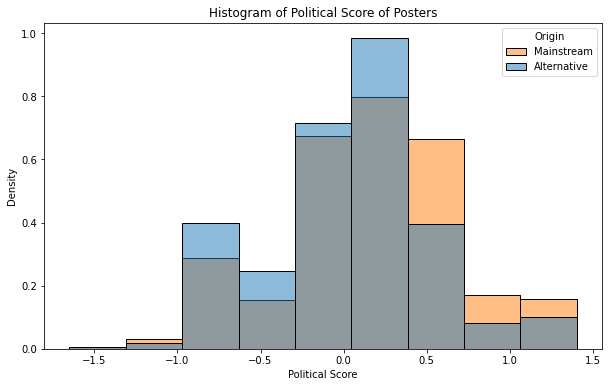

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=combined_posters_pol,
    x="mean_pol_score",
    hue="Origin",
    bins=9,
    kde=False,
    stat="density",
    common_norm=False,
    palette={"Mainstream": "#1f77b4", "Alternative": "#ff7f0e"},
    hue_order=["Mainstream", "Alternative"]
)
plt.title("Histogram of Political Score of Posters")
plt.xlabel("Political Score")
plt.ylabel("Density")
plt.legend(title="Origin", labels=["Mainstream", "Alternative"])
plt.show()


## Commenters

In [27]:

# For conventional commenters change data form to long
conv_commenters_long = pd.melt(conv_commenters, id_vars=["Username"], var_name="Number", value_name="Subreddit")
conv_commenters_long["Number"] = conv_commenters_long["Number"].str.replace("Subreddit_", "")
conv_commenters_long=conv_commenters_long[conv_commenters_long["Number"]!="original_subreddits"]

conv_commenters_long["pol_score"]=conv_commenters_long["Subreddit"].map(pol_subs_dict)

# I want to see the political subreddits of the conventional commenters
conv_commenters_long=conv_commenters_long[["Username","Subreddit","pol_score"]]
conv_commenters_long=conv_commenters_long.dropna()

conv_commenters_pol = conv_commenters_long.groupby("Username").agg(
    mean_pol_score=("pol_score", "mean"),
    sum_pol_score=("pol_score", "sum"),
    med_pol_score=("pol_score", "median")
).reset_index()


# Following the same process for alternative commenters
alt_commenters_long = pd.melt(alt_commenters, id_vars=["Username"], var_name="Number", value_name="Subreddit")
alt_commenters_long["Number"] = alt_commenters_long["Number"].str.replace("Subreddit_", "")
alt_commenters_long=alt_commenters_long[alt_commenters_long["Number"]!="original_subreddits"]
alt_commenters_long["pol_score"]=alt_commenters_long["Subreddit"].map(pol_subs_dict)
# I want to see the political subreddits of the alternative commenters
alt_commenters_long=alt_commenters_long[["Username","Subreddit","pol_score"]]
alt_commenters_long=alt_commenters_long.dropna()
alt_commenters_pol = alt_commenters_long.groupby("Username").agg(
    mean_pol_score=("pol_score", "mean"),
    sum_pol_score=("pol_score", "sum"),
    med_pol_score=("pol_score", "median")
).reset_index()


# I want to combine the conventional and alternative commenters but keep data on the origin
conv_commenters_pol["Origin"]="Mainstream"
alt_commenters_pol["Origin"]="Alternative"
combined_commenters_pol=pd.concat([conv_commenters_pol,alt_commenters_pol],ignore_index=True)

In [28]:
len(alt_commenters_pol)/len(alt_commenters), len(conv_commenters_pol)/len(conv_commenters)

(0.1766083012242111, 0.17717333333333332)

In [29]:
# I want to create a df of the ratio of commenters for the two groups who are in each of the 0.5 intervals from -2 to 2
bins = pd.IntervalIndex.from_tuples([(-2, -1.5), (-1.5, -1), (-1, -0.5), (-0.5, 0), (0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2)])
combined_commenters_pol["bin"] = pd.cut(combined_commenters_pol["mean_pol_score"], bins=bins)
combined_commenters_pol["count"] = 1
# I want see the percentage of users in each bin  for each Origin next to each other
combined_commenters_pol_ratio = combined_commenters_pol.groupby(["Origin", "bin"]).agg(
    count=("count", "sum")
).reset_index()
combined_commenters_pol_ratio["total"] = combined_commenters_pol_ratio.groupby("Origin")["count"].transform("sum")
combined_commenters_pol_ratio["ratio"] = combined_commenters_pol_ratio["count"] / combined_commenters_pol_ratio["total"]
combined_commenters_pol_ratio["bin"] = combined_commenters_pol_ratio["bin"].astype(str)
combined_commenters_pol_ratio = combined_commenters_pol_ratio.pivot(index="bin", columns="Origin", values="ratio").reset_index()

# Sort the bins starting from 2-1.5 and then going down, handling negative numbers correctly
combined_commenters_pol_ratio["bin"] = combined_commenters_pol_ratio["bin"].str.replace("Interval\\(", "", regex=True).str.replace("\\)", "", regex=True)
combined_commenters_pol_ratio["bin"] = combined_commenters_pol_ratio["bin"].str.replace(",", "-").str.replace(" ", "")
combined_commenters_pol_ratio["bin"] = pd.Categorical(combined_commenters_pol_ratio["bin"], 
                                                   categories=["(1.5-2.0]", "(1.0-1.5]", "(0.5-1.0]", "(0.0-0.5]", 
                                                               "(-0.5-0.0]", "(-1.0--0.5]", "(-1.5--1.0]", "(-2.0--1.5]"],
                                                   ordered=True)
combined_commenters_pol_ratio = combined_commenters_pol_ratio.sort_values("bin", ascending=True)


# Change the Alternative and Mainstream columsn to be percentages
combined_commenters_pol_ratio["Alternative"] = combined_commenters_pol_ratio["Alternative"] * 100
combined_commenters_pol_ratio["Mainstream"] = combined_commenters_pol_ratio["Mainstream"] * 100

# Format as percentage
combined_commenters_pol_ratio["Alternative"] = combined_commenters_pol_ratio["Alternative"].map("{:.2f}%".format)
combined_commenters_pol_ratio["Mainstream"] = combined_commenters_pol_ratio["Mainstream"].map("{:.2f}%".format)
combined_commenters_pol_ratio = combined_commenters_pol_ratio.rename(columns={"bin": "Political Score"})

combined_commenters_pol_ratio

# Merge with combined_posters_pol_ratio on political score
combined_commenters_pol_ratio.merge(combined_posters_pol_ratio, on="Political Score", how="outer", suffixes=("_commenters", "_posters"))





/var/folders/g1/m2905s6d6093hshyj_v9xm380000gn/T/ipykernel_11441/3865076070.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_commenters_pol_ratio = combined_commenters_pol.groupby(["Origin", "bin"]).agg(


Origin,Political Score,Alternative_commenters,Mainstream_commenters,Alternative_posters,Mainstream_posters
0,(1.5-2.0],0.00%,0.00%,0.00%,0.00%
1,(1.0-1.5],3.10%,1.76%,6.36%,3.76%
2,(0.5-1.0],10.63%,5.79%,15.79%,11.27%
3,(0.0-0.5],63.16%,68.45%,48.03%,50.61%
4,(-0.5-0.0],15.37%,13.92%,17.43%,17.02%
5,(-1.0--0.5],6.99%,9.58%,11.18%,16.46%
6,(-1.5--1.0],0.69%,0.47%,1.10%,0.66%
7,(-2.0--1.5],0.06%,0.03%,0.11%,0.22%


## Scope of analysis

In [30]:
group_sizes = pd.DataFrame({
    "Group": ["Mainstream Posters", "Alternative Posters", "Mainstream Commenters", "Alternative Commenters"],
    "Total Users": [len(conv_posters), len(alt_posters), len(conv_commenters), len(alt_commenters)],
    "Political Users": [len(conv_posters_pol), len(alt_posters_pol), len(conv_commenters_pol), len(alt_commenters_pol)],
    "Percentage of Political Users": [
        len(conv_posters_pol) / len(conv_posters) * 100,
        len(alt_posters_pol) / len(alt_posters) * 100,
        len(conv_commenters_pol) / len(conv_commenters) * 100,
        len(alt_commenters_pol) / len(alt_commenters) * 100
    ],
    "Mean Pol_Score": [
        conv_posters_pol["mean_pol_score"].mean(),
        alt_posters_pol["mean_pol_score"].mean(),
        conv_commenters_pol["mean_pol_score"].mean(),
        alt_commenters_pol["mean_pol_score"].mean()
  ]
})


  ,
    "Median Pol_Score": [
        conv_posters_pol["med_pol_score"].median(),
        alt_posters_pol["med_pol_score"].median(),
        conv_commenters_pol["med_pol_score"].median(),
        alt_commenters_pol["med_pol_score"].median()
    ],
    "Sum Pol_Score": [
        conv_posters_pol["sum_pol_score"].sum(),
        alt_posters_pol["sum_pol_score"].sum(),
        conv_commenters_pol["sum_pol_score"].sum(),
        alt_commenters_pol["sum_pol_score"].sum()
    ]

In [31]:
group_sizes

,Group,Total Users,Political Users,Percentage of Political Users,Mean Pol_Score
0,Mainstream Posters,6565,905,13.785225,0.015089
1,Alternative Posters,6177,912,14.764449,0.142976
2,Mainstream Commenters,75000,13288,17.717333,0.072334
3,Alternative Commenters,61509,10863,17.660830,0.154068


In [36]:
# Perform an independent t-test to compare mean political scores between Mainstream and Alternative posters
from scipy.stats import ttest_ind

mainstream_scores = combined_posters_pol[combined_posters_pol['Origin'] == 'Mainstream']['mean_pol_score']
alternative_scores = combined_posters_pol[combined_posters_pol['Origin'] == 'Alternative']['mean_pol_score']

t_stat, p_value = ttest_ind(mainstream_scores, alternative_scores, equal_var=False)  # Welch's t-test
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The difference in mean political scores is statistically significant (p < 0.05).")
else:
    print("The difference in mean political scores is not statistically significant (p >= 0.05).")


# Perform an independent t-test to compare mean political scores between Mainstream and Alternative commenters
mainstream_scores_commenters = combined_commenters_pol[combined_commenters_pol['Origin'] == 'Mainstream']['mean_pol_score']
alternative_scores_commenters = combined_commenters_pol[combined_commenters_pol['Origin'] == 'Alternative']['mean_pol_score']
t_stat_commenters, p_value_commenters = ttest_ind(mainstream_scores_commenters, alternative_scores_commenters, equal_var=False)  # Welch's t-test
print(f"t-statistic (commenters): {t_stat_commenters:.3f}, p-value (commenters): {p_value_commenters:.4f}")


# Add the t-test result to a new dataframe
t_test_results = pd.DataFrame({
    "Mean comparison": ["Posters", "Commenters"],
    "t-statistic": [t_stat, t_stat_commenters],
    "p-value": [p_value, p_value_commenters]
})
t_test_results["Significance 0.05"] = t_test_results["p-value"].apply(lambda x: "Significant" if x < 0.05 else "Not Significant")
#format p-value to 2 decimal places
t_test_results["p-value"] = t_test_results["p-value"].map("{:.2f}".format)
#format t-statistic to 2 decimal places
t_test_results["t-statistic"] = t_test_results["t-statistic"].map("{:.2f}".format)

t_test_results

t-statistic: -5.124, p-value: 0.0000
The difference in mean political scores is statistically significant (p < 0.05).
t-statistic (commenters): -14.800, p-value (commenters): 0.0000


,Mean comparison,t-statistic,p-value,Significance 0.05
0,Posters,-5.12,0.00,Significant
1,Commenters,-14.80,0.00,Significant


/var/folders/g1/m2905s6d6093hshyj_v9xm380000gn/T/ipykernel_10352/4183153666.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=combined_commenters_pol, x="Origin", y="med_pol_score", palette="muted", inner="quartile")


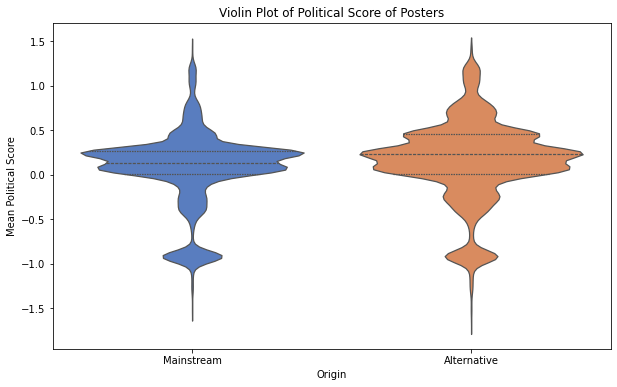

In [14]:
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


# I want to visualize the distribution of combined_posters_pol with a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_commenters_pol, x="Origin", y="med_pol_score", palette="muted", inner="quartile")
plt.title("Violin Plot of Political Score of Posters")
plt.xlabel("Origin")
plt.ylabel("Mean Political Score")
plt.show()


# Subreddit drivers

In [15]:
# for the pol subreddit list, I want to compile the frequency of each subreddit in the list
pol_subs=pol_subs[["subreddit","ca_score"]]

# Create a new column with the count of each subreddit in alt_posters
alt_posters_subs = alt_posters.iloc[:, 1:].values.flatten()
alt_posters_subs = pd.Series(alt_posters_subs).value_counts().reset_index()
alt_posters_subs.columns = ["subreddit", "alt_post_count"]
# Merge with pol_subs
pol_subs = pol_subs.merge(alt_posters_subs, on="subreddit", how="left")
pol_subs["alt_post_count"] = pol_subs["alt_post_count"].fillna(0)

# Create a new column with the count of each subreddit in conv_posters
conv_posters_subs = conv_posters.iloc[:, 1:].values.flatten()
conv_posters_subs = pd.Series(conv_posters_subs).value_counts().reset_index()
conv_posters_subs.columns = ["subreddit", "conv_post_count"]
# Merge with pol_subs
pol_subs = pol_subs.merge(conv_posters_subs, on="subreddit", how="left")
pol_subs["conv_post_count"] = pol_subs["conv_post_count"].fillna(0)

# Create a new column with the count of each subreddit in alt_commenters
alt_commenters_subs = alt_commenters.iloc[:, 1:].values.flatten()
alt_commenters_subs = pd.Series(alt_commenters_subs).value_counts().reset_index()
alt_commenters_subs.columns = ["subreddit", "alt_comment_count"]
# Merge with pol_subs
pol_subs = pol_subs.merge(alt_commenters_subs, on="subreddit", how="left")
pol_subs["alt_comment_count"] = pol_subs["alt_comment_count"].fillna(0)

# Create a new column with the count of each subreddit in conv_commenters
conv_commenters_subs = conv_commenters.iloc[:, 1:].values.flatten()
conv_commenters_subs = pd.Series(conv_commenters_subs).value_counts().reset_index()
conv_commenters_subs.columns = ["subreddit", "conv_comment_count"]
# Merge with pol_subs
pol_subs = pol_subs.merge(conv_commenters_subs, on="subreddit", how="left")
pol_subs["conv_comment_count"] = pol_subs["conv_comment_count"].fillna(0)





In [16]:
# sort the dataframe by alt_post_count
pol_subs = pol_subs.sort_values(by="alt_post_count", ascending=False)


In [17]:
pol_subs

,subreddit,ca_score,alt_post_count,conv_post_count,alt_comment_count,conv_comment_count
137,conspiracy,0.456592,581.0,92.0,6044.0,2625.0
465,politics,0.073351,297.0,376.0,5718.0,8681.0
36,antiwork,-0.918964,202.0,333.0,1429.0,2385.0
496,redscarepod,-0.220005,180.0,100.0,1800.0,917.0
409,news,0.269071,144.0,227.0,2719.0,4721.0
...,...,...,...,...,...,...
680,yangforpresidenthq,-0.887822,0.0,0.0,0.0,0.0
681,yanggang,-1.028038,0.0,0.0,0.0,0.0
682,yangmemes,-1.043061,0.0,0.0,0.0,0.0
683,youseecomrade,0.424019,0.0,0.0,0.0,0.0


In [18]:
# Change conv to main in the column names
pol_subs = pol_subs.rename(columns={"conv_post_count": "main_post_count", "conv_comment_count": "main_comment_count"})
# Calculate the difference between the alt_post_count and conv_post_count
pol_subs["diff_post_count"] = pol_subs["alt_post_count"] - pol_subs["main_post_count"]
# Calculate the difference between the alt_comment_count and conv_comment_count
pol_subs["diff_comment_count"] = pol_subs["alt_comment_count"] - pol_subs["main_comment_count"]

# Create a pol_post_df with the relevant columns
pol_post_df = pol_subs[["subreddit", "ca_score", "alt_post_count", "main_post_count", "diff_post_count"]]
# Create a pol_comment_df with the relevant columns
pol_comment_df = pol_subs[["subreddit", "ca_score", "alt_comment_count", "main_comment_count", "diff_comment_count"]]
# Sort the pol_post_df by diff_post_count
pol_post_df = pol_post_df.sort_values(by="diff_post_count", ascending=False)
# Sort the pol_comment_df by diff_comment_count
pol_comment_df = pol_comment_df.sort_values(by="diff_comment_count", ascending=False)


In [22]:
pol_comment_df.tail(10)

,subreddit,ca_score,alt_comment_count,main_comment_count,diff_comment_count
414,niceguys,0.606294,84.0,299.0,-215.0
238,france,0.008309,193.0,420.0,-227.0
290,iamatotalpieceofshit,0.257693,313.0,544.0,-231.0
660,weed,0.003425,412.0,656.0,-244.0
672,women,0.259994,229.0,503.0,-274.0
166,democrats,-0.390415,395.0,676.0,-281.0
36,antiwork,-0.918964,1429.0,2385.0,-956.0
675,worldnews,0.232916,3876.0,4922.0,-1046.0
409,news,0.269071,2719.0,4721.0,-2002.0
465,politics,0.073351,5718.0,8681.0,-2963.0


## Overlap of subreddits

In [11]:
# Melt alt_posters to create a single column with all subreddits
alt_posters_long = pd.melt(alt_posters, id_vars=["Username"], var_name="Number", value_name="Subreddit")
# If you want only the subreddit column:
alt_posters_subreddits = alt_posters_long["Subreddit"]

conv_posters_long = pd.melt(conv_posters, id_vars=["Username"], var_name="Number", value_name="Subreddit")
# If you want only the subreddit column:
conv_posters_subreddits = conv_posters_long["Subreddit"]

# Filter out the subreddits that are not in the political subreddit list
alt_posters_subreddits = alt_posters_subreddits[alt_posters_subreddits.isin(pol_subs["subreddit"])]
conv_posters_subreddits = conv_posters_subreddits[conv_posters_subreddits.isin(pol_subs["subreddit"])]

#Create a dataframe with the alt_posters_subreddits that are not in the conv_posters_subreddits
alt_posters_subreddits_only = pd.DataFrame(alt_posters_subreddits)
alt_posters_subreddits_only = alt_posters_subreddits_only[~alt_posters_subreddits_only["Subreddit"].isin(conv_posters_subreddits)]
# Create a dataframe with the conv_posters_subreddits that are not in the alt_posters_subreddits
conv_posters_subreddits_only = pd.DataFrame(conv_posters_subreddits)
conv_posters_subreddits_only = conv_posters_subreddits_only[~conv_posters_subreddits_only["Subreddit"].isin(alt_posters_subreddits)]


# Count each subreddit in the alt_posters_subreddits_only
alt_posters_subreddits_only = alt_posters_subreddits_only.value_counts().reset_index()
alt_posters_subreddits_only.columns = ["Subreddit", "Count"]
# Count each subreddit in the conv_posters_subreddits_only
conv_posters_subreddits_only = conv_posters_subreddits_only.value_counts().reset_index()
conv_posters_subreddits_only.columns = ["Subreddit", "Count"]


#Sort the alt_posters_subreddits_only by count
alt_posters_subreddits_only = alt_posters_subreddits_only.sort_values(by="Count", ascending=False)
#Sort the conv_posters_subreddits_only by count
conv_posters_subreddits_only = conv_posters_subreddits_only.sort_values(by="Count", ascending=False)

# Create a new column with the ca_score of each subreddit in alt_posters_subreddits_only
alt_posters_subreddits_only["ca_score"] = alt_posters_subreddits_only["Subreddit"].map(pol_subs_dict)
# Create a new column with the ca_score of each subreddit in conv_posters_subreddits_only
conv_posters_subreddits_only["ca_score"] = conv_posters_subreddits_only["Subreddit"].map(pol_subs_dict)

In [14]:
conv_posters_subreddits_only

,Subreddit,Count,ca_score
0,uofmn,4,0.121313
1,obama,4,0.138467
2,dontwalkrun_youtube,2,0.189724
3,mildlydisgusting,2,0.422463
4,gaymemes,2,-0.352428
5,dsa,2,-1.511673
6,actualliberalgunowner,1,0.396246
7,democraticparty,1,-1.067660
8,justicedemocrats,1,-1.155334
9,monkeys,1,0.357535


In [15]:
alt_commenters_long= pd.melt(alt_commenters, id_vars=["Username"], var_name="Number", value_name="Subreddit")
# If you want only the subreddit column:
alt_commenters_subreddits = alt_commenters_long["Subreddit"]
conv_commenters_long = pd.melt(conv_commenters, id_vars=["Username"], var_name="Number", value_name="Subreddit")
# If you want only the subreddit column:
conv_commenters_subreddits = conv_commenters_long["Subreddit"]
# Filter out the subreddits that are not in the political subreddit list
alt_commenters_subreddits = alt_commenters_subreddits[alt_commenters_subreddits.isin(pol_subs["subreddit"])]
conv_commenters_subreddits = conv_commenters_subreddits[conv_commenters_subreddits.isin(pol_subs["subreddit"])]
#Create a dataframe with the alt_commenters_subreddits that are not in the conv_commenters_subreddits
alt_commenters_subreddits_only = pd.DataFrame(alt_commenters_subreddits)
alt_commenters_subreddits_only = alt_commenters_subreddits_only[~alt_commenters_subreddits_only["Subreddit"].isin(conv_commenters_subreddits)]
# Create a dataframe with the conv_commenters_subreddits that are not in the alt_commenters_subreddits
conv_commenters_subreddits_only = pd.DataFrame(conv_commenters_subreddits)
conv_commenters_subreddits_only = conv_commenters_subreddits_only[~conv_commenters_subreddits_only["Subreddit"].isin(alt_commenters_subreddits)]
# Count each subreddit in the alt_commenters_subreddits_only
alt_commenters_subreddits_only = alt_commenters_subreddits_only.value_counts().reset_index()
alt_commenters_subreddits_only.columns = ["Subreddit", "Count"]
# Count each subreddit in the conv_commenters_subreddits_only
conv_commenters_subreddits_only = conv_commenters_subreddits_only.value_counts().reset_index()
conv_commenters_subreddits_only.columns = ["Subreddit", "Count"]
#Sort the alt_commenters_subreddits_only by count
alt_commenters_subreddits_only = alt_commenters_subreddits_only.sort_values(by="Count", ascending=False)
#Sort the conv_commenters_subreddits_only by count

conv_commenters_subreddits_only = conv_commenters_subreddits_only.sort_values(by="Count", ascending=False)
# Create a new column with the ca_score of each subreddit in alt_commenters_subreddits_only
alt_commenters_subreddits_only["ca_score"] = alt_commenters_subreddits_only["Subreddit"].map(pol_subs_dict)
# Create a new column with the ca_score of each subreddit in conv_commenters_subreddits_only
conv_commenters_subreddits_only["ca_score"] = conv_commenters_subreddits_only["Subreddit"].map(pol_subs_dict)



In [18]:
alt_commenters_subreddits_only


,Subreddit,Count,ca_score
0,jimmydore,12,-1.147970
1,censorship,6,0.331578
2,restorethefourth,3,0.136579
3,bernieblindness,3,-1.649417
4,newworldorder,3,0.474945
5,againstmensrights,2,0.434437
6,randpaul,2,0.890872
7,propaganda,2,-0.258842
8,voluntarism,2,0.531036
9,redacted,2,1.134769


t-statistic: -5.124, p-value: 0.0000
The difference in mean political scores is statistically significant (p < 0.05).
